In [1]:
!date

Mon Oct 25 10:40:11 EDT 2021


In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
whos

Interactive namespace is empty.


In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

### System set-up

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [10]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187           4         180           0           2         180
Swap:            11           0          11


In [11]:
!nvidia-smi

Mon Oct 25 10:40:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   40C    P0    70W / 300W |    456MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [12]:
# CHECK GPU
import nvidia_smi
try:
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

#     print("Total memory:", (info.total/1024/1024/1024))
#     print("Free memory:", (info.free/1024/1024/1024))
#     print("Used memory:", (info.used/1024/1024/1024))

    print(f"Total GPU memory: {(info.total/1024/1024/1024):.2f} GB")
    print(f"Free GPU memory: {(info.free/1024/1024/1024):.2f} GB")
    print(f"Used GPU memory: {(info.used/1024/1024/1024):.2f} GB")
    
    nvidia_smi.nvmlShutdown()
except:
    pass

Total GPU memory: 15.78 GB
Free GPU memory: 15.34 GB
Used GPU memory: 0.45 GB


## Prep analysis

In [13]:
import os
from datetime import datetime; now = datetime.now

#analysis_name = 'VAE_'+str(now())
analysis_name = 'VAE_'+'test'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
print(analysis_name)

VAE_test


In [14]:
%%time
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP
tqdm = partial(tqdm, position=0, leave=True) 

CPU times: user 7.6 s, sys: 294 ms, total: 7.89 s
Wall time: 10.3 s


In [18]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
#data_dir = '../Assets/fc_mats_32smooth_new/'
data_dir = '../Assets/fc_mats_32smooth_new-demean/'

In [19]:
files = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
files.sort()
files[0:5]

['sub-CMUa0050642.npy',
 'sub-CMUa0050646.npy',
 'sub-CMUa0050647.npy',
 'sub-CMUa0050649.npy',
 'sub-CMUa0050653.npy']

In [20]:
has_file = np.array([os.path.exists(os.path.join(data_dir,sub + '.npy')) for sub in df['bids_folder'].values])
print(has_file.mean())

assert has_file.mean()==1.0, 'fuck'

1.0


In [21]:
subs_with_matFiles = [file.split('.')[0] for file in files]
df = df.iloc[np.array([sub in subs_with_matFiles for sub in df['bids_folder'].values])]
n_subs = len(df)
print(n_subs)

# Check if subject has .nii file
has_file = np.array([os.path.exists(os.path.join(data_dir,sub + '.npy')) for sub in df['bids_folder'].values])
print(has_file.mean())
assert has_file.mean()==1.0, 'fuck'

assert len(subs_with_matFiles)==len(df),'no'
df = df.sort_values(by='bids_folder')
assert all([subs_with_matFiles[i]==df['bids_folder'].values[i] for i in range(n_subs)]), 'out of order'

df.index = np.arange(n_subs)

1048
1.0


In [22]:
## DATA LOADER
class vae_data_loader():
    ''' this is the info'''
    def __init__(self,data_dir,df,batch_size=32):
        #self.data = data
        #self.n = data.shape[0]
        self.n = len(df)
        self.data_dir = data_dir
        self.epoch = -1
        self.batch_size = batch_size
        self.df = df
        
        self.new_epoch()
        self.n_batches = int(self.n/self.batch_size)
        
    def new_epoch(self):
        #self.df = self.df.iloc[np.random.permutation(np.arange(self.n))]
        #self.df.index = np.arange(self.n)
        self.idxs = np.arange(self.n)
        
        #self.asd_idxs = np.random.permutation(self.asd_idxs)
        self.idxs = np.random.permutation(self.idxs)
        self.df = self.df.iloc[self.idxs]
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
       # self.batch_asd_idx = self.asd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_idx = self.idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        #self.batch_asd = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_asd_idx]])
        self.batch = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_idx]])
        self.batch_df = self.df.iloc[self.batch_idx,:]
        
        #self.batch = self.batch/2
        #self.batch_td = self.batch_td/2
        
    
        return self.batch,self.batch_df

In [23]:
batch_size = 32
data_loader = vae_data_loader(data_dir=data_dir, df=df, batch_size=batch_size)
data_batch,batch_df = data_loader.get_batch()
assert all(( data_batch.min()>0 , data_batch.max()<1 )), 'range not 0-1'

In [24]:
# data_loader = vae_data_loader(data_dir=data_dir, df=df, batch_size=n_subs)
# data_all,df_all = data_loader.get_batch()
# data_all.shape

In [25]:
print(f'n_batches : {data_loader.n_batches}')

n_batches : 32


In [82]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
      args (tensor): mean and log of variance of Q(z|X)
    # Returns:
      z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_fMRI_VAE_4D(input_shape=(48,48,48,51),
                   latent_dim=2, 
                   batch_size = 32, 
                   disentangle=False, 
                   gamma=1,
                    beta=1,
                   kernel_size = 3,
                   filters = 16,
                   bias=True,
                   intermediate_dim = 128,
                   nlayers = 2,
                   learning_rate=0.001,
                   opt=None):


    image_size, _, _, channels = input_shape
    
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for i in range(nlayers):
        filters *= 2
        x = Conv3D(filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(intermediate_dim, activation='relu',use_bias=bias,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=5),bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=40))(x)
    z_mean = Dense(latent_dim, name='z_mean',use_bias=bias,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=5))(x)
    #z_mean = Dense(latent_dim, name='z_mean',use_bias=bias,kernel_initializer=tf.keras.initializers.RandomUniform(minval=-50,maxval=50))(x)
    z_log_var = Dense(latent_dim, name='z_log_var',use_bias=bias,kernel_initializer=tf.keras.initializers.RandomUniform(minval = -2.3, maxval = -.69))(x) # .1 to .5 in log

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu',use_bias=bias)(latent_inputs)
    x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu',use_bias=bias)(x)
    x = Reshape((shape[1], shape[2], shape[3],shape[4]))(x)

    for i in range(nlayers):
        x = Conv3DTranspose(filters=filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=2,
                          use_bias=bias,
                          padding='same')(x)
        filters //= 2

    outputs = Conv3DTranspose(filters=channels,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            use_bias=bias,
                            name='decoder_output')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    #     decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:int(latent_dim/2)])(z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:int(latent_dim/2)])(z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),int(latent_dim/2):])(z)
        s2 = Lambda(lambda x: x[int(batch_size/2):,int(latent_dim/2):])(z)
        
        q_bar = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z2], axis=1),
          tf.keras.layers.concatenate([s2, z1], axis=1)],
          axis=0)
        q = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z1], axis=1),
          tf.keras.layers.concatenate([s2, z2], axis=1)],
          axis=0)
        
#         q_bar_score = discriminator(q_bar)
#         q_score = discriminator(q)        
#         tc_loss = K.log(q_score / (1 - q_score)) 

        q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
        q_score = (discriminator(q)+.1) *.85 
        tc_loss = K.log(q_score / (1 - q_score)) 

        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)

    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    
#     brain_idx = abs(K.flatten(inputs))>1e-3
#     reconstruction_loss_brain = mse(K.flatten(inputs)[brain_idx], K.flatten(outputs)[brain_idx])
#     reconstruction_loss_notbrain = mse(K.flatten(inputs)[~brain_idx], K.flatten(outputs)[~brain_idx])
#     reconstruction_loss = reconstruction_loss_brain*10 + reconstruction_loss_notbrain*1
#     reconstruction_loss *= image_size * image_size * image_size


    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    if disentangle:
        vae_loss = K.mean(reconstruction_loss) + beta*K.mean(kl_loss) + gamma * K.mean(tc_loss) + K.mean(discriminator_loss)
    else:
        vae_loss = K.mean(reconstruction_loss) + beta*K.mean(kl_loss)
        
    vae.add_loss(vae_loss)

    if type(opt)==type(None):
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
        
    vae.compile(optimizer=opt)
    

    if disentangle:
        vae.metrics_tensors = [reconstruction_loss, kl_loss, tc_loss, discriminator_loss]
        #     vae.summary()
    return encoder, decoder, vae

In [83]:
def vae_dashboard():
    predictions = vae.predict(data_batch)
    sigma = (np.e ** encoder.predict(data_batch)[1]).mean()
    sigmas.append(sigma)

    mu = encoder.predict(data_batch)[0]
    mus.append(np.mean([mu[:,0].std() for i in range(mu.shape[1])]))

    prediction = predictions

    cmat_actual = np.corrcoef(data_batch.reshape(data_batch.shape[0],-1))
    cmat_pred = np.corrcoef(prediction.reshape(prediction.shape[0],-1))
    c_sim.append(np.corrcoef(get_triu(cmat_pred),get_triu(cmat_actual))[0,1])


    ### PROGRESS PLOTTING
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #Organise figure
    ncols = 4;nrows=7
    if np.mod(i,5)==0:
        plt.close()
    plt.subplots(nrows,ncols,figsize=(15,15)); # MAKE THE FIGURE


    # ##### SUBPLOT 1 & 2 ##### 

    plt.subplot(nrows,ncols/2,1) # PLOT LOSS
    xs = np.arange(len(loss))+1
    m,b = np.polyfit(xs,loss,deg=1)
    plt.plot(loss)
    plt.plot(xs, m*xs + b)
    plt.title(f'Epoch {data_loader.epoch} batch {data_loader.b}/{data_loader.n_batches} | Loss {loss[-1]:.2f}, beta: {m:.4f}')

    ##### SUBPLOT 3 ##### 
    plt.subplot(nrows,ncols,3) # PLOT LOSS LAST 50
    hb = 50
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        plt.plot(plot_loss)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'Loss last {hb} it, beta {m:.4f}')

    ##### SUBPLOT 4 ##### 
    plt.subplot(nrows,ncols,4)
    plt.hist(prediction[0,:,:,:,0].flatten(),alpha=.5)
    plt.hist(data_batch[0,:,:,:,0].flatten(),alpha=.5)
    plt.legend(['predicted','actual'])
    plt.title('in/out histograms')

    ##### SUBPLOT 5 ##### 
    plt.subplot(nrows,ncols,5) #RSA over time
    plt.plot(c_sim)
    plt.title(f'in/out RSA: {c_sim[-1].round(2)}')

    if len(c_sim)>5: # PLOT LS LINE
        xs = np.arange(len(c_sim))+1
        m,b = np.polyfit(xs,c_sim,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'in/out RSA: {c_sim[-1].round(2)}, b={m:.4f}')


    ##### SUBPLOT 6 ##### 
    plt.subplot(nrows,ncols,6)
    if len(c_sim)>hb:
        #plot_loss = loss[-hb::]
        xs = np.arange(len(c_sim[-hb::]))
        m,b = np.polyfit(xs,c_sim[-hb::],deg=1)
        plt.plot(c_sim[-hb::])
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'in/outRSA last {hb} it, b={m:.4f}')

    # ##### SUBPLOT 7 ##### 
    # plt.subplot(nrows,ncols,7)
    # lbls = ['age','sex','fiq','dsm','site','ados'];
    # xs = np.arange(len(lbls));
    # plt.bar(xs,batch_rsas[0:6]);
    # plt.xticks(xs,labels=lbls);
    # plt.title('S RSA')

    # ##### SUBPLOT 8 ##### 
    # plt.subplot(nrows,ncols,8)
    # lbls = ['age','sex','fiq','dsm','site','ados'];
    # xs = np.arange(len(lbls));
    # plt.bar(xs,batch_rsas[6::]);
    # plt.xticks(xs,labels=lbls);
    # plt.title('Z RSA')


    ##### SUBPLOT 9 ##### 
    plt.subplot(nrows,ncols,9)
    plt.plot(sigmas)
    plt.title(f'sigmas | {sigmas[-1]:.4f}')


    ##### SUBPLOT 10 ##### 
    plt.subplot(nrows,ncols,10)
    plt.plot(mus)
    plt.title(f'Mu variance {mus[-1]:.4f}')


    ##### SUBPLOT 11 ##### 
    plt.subplot(nrows,ncols,11)
    sns.heatmap(cmat_actual,xticklabels=[],yticklabels=[])
    plt.title('input RSA')

    ##### SUBPLOT 12 ##### 
    plt.subplot(nrows,ncols,12)
    sns.heatmap(cmat_pred,xticklabels=[],yticklabels=[])
    plt.title('output RSA')

    #############################################
    ###################Reconstructions###########
    #############################################

    ##### SUBPLOT 13 #####     
    plt.subplot(nrows,ncols,13)
    rand_sub = np.random.randint(low=0,high=data_batch.shape[0])
    rand_map = np.random.randint(low=0,high=data_batch.shape[4])

    plt.imshow(np.rot90(data_batch[rand_sub,:,16,:,rand_map]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 14 #####     
    plt.subplot(nrows,ncols,14)
    plt.imshow(np.rot90(prediction[rand_sub,:,16,:,rand_map]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 15 #####     
    plt.subplot(nrows,ncols,15)
    plt.imshow(np.rot90(data_batch[rand_sub,16,:,:,rand_map]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 16 #####                                             
    plt.subplot(nrows,ncols,16)
    plt.imshow(np.rot90(prediction[rand_sub,16,:,:,rand_map]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 17 #####     
    plt.subplot(nrows,ncols,17)
    plt.imshow(np.rot90(data_batch[rand_sub,6,:,:,rand_map]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 18 #####                                             
    plt.subplot(nrows,ncols,18)
    plt.imshow(np.rot90(prediction[rand_sub,6,:,:,rand_map]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 19 #####     
    plt.subplot(nrows,ncols,19)
    plt.imshow(data_batch[rand_sub,:,:,16,rand_map])
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 20 #####     
    plt.subplot(nrows,ncols,20)
    plt.imshow(prediction[rand_sub,:,:,16,rand_map])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')


    # #############################################
    # ################### LOSSES ##################
    # #############################################


    # predictions = cvae.predict([patient_batch,control_batch])
    input_shape = data_shape[1:]

    reconstruction_loss = tf.keras.losses.mse(K.flatten(data_batch), K.flatten(predictions)) 
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2] * input_shape[3]

    z_mean, z_log_var, z = encoder.predict(data_batch)

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5


    discriminator = Dense(1, activation='sigmoid')

    z1 = Lambda(lambda x: x[:int(batch_size/2),:int(latent_dim/2)])(z)
    z2 = Lambda(lambda x: x[int(batch_size/2):,:int(latent_dim/2)])(z)
    s1 = Lambda(lambda x: x[:int(batch_size/2),int(latent_dim/2):])(z)
    s2 = Lambda(lambda x: x[int(batch_size/2):,int(latent_dim/2):])(z)

    q_bar = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z2], axis=1),
      tf.keras.layers.concatenate([s2, z1], axis=1)],
      axis=0)
    q = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z1], axis=1),
      tf.keras.layers.concatenate([s2, z2], axis=1)],
      axis=0)


    q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
    q_score = (discriminator(q)+.1) *.85 
    tc_loss = K.log(q_score / (1 - q_score)) 

    discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)

    loss_mse.append(reconstruction_loss.numpy())
    loss_kl.append(kl_loss.numpy().mean())
    loss_dc.append(tc_loss.numpy().mean())
    loss_tc.append(discriminator_loss.numpy().mean())


    plt.subplot(nrows,ncols,21) # MSE 
    plt.plot(loss_mse)
    plt.title(f'MSE | {loss_mse[-1]:.4f}')

    plt.subplot(nrows,ncols,22) # KL loss
    plt.plot(loss_kl)
    plt.title(f'KL | {loss_kl[-1]:.4f}')    


    plt.subplot(nrows,ncols,23) # TC     
    plt.plot(loss_tc)
    plt.title(f'Total Correlation loss | {loss_tc[-1]:.4f}')    


    plt.subplot(nrows,ncols,24) # Disc         
    plt.plot(loss_dc)
    plt.title(f'discriminator_loss | {loss_dc[-1]:.4f}')    


    Z = encoder.predict(data_batch)

    plt.subplot(nrows,ncols,25)
    plt.hist(Z[2].flatten(),alpha=.5);
    plt.title('Z')


    plt.subplot(nrows,ncols,26)
    plt.hist(Z[0].flatten(),alpha=.5);
    plt.title('Mus')


    plt.subplot(nrows,ncols,27)
    plt.hist(Z[1].flatten(),alpha=.5);
    plt.title('Sigmas')


    plt.tight_layout()
    plt.show()
    sys.stdout.flush()

In [84]:
%time
from helper_funcs import *
from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt

CPU times: user 9 µs, sys: 6 µs, total: 15 µs
Wall time: 28.4 µs


In [85]:
data_shape = np.hstack((n_subs,data_batch.shape[1::]))
print(data_shape)

[1048   32   32   32   51]


In [86]:
batch_size = 32
latent_dim = 8

encoder, decoder, vae = get_fMRI_VAE_4D(input_shape=data_shape[1::],
                   latent_dim = latent_dim, 
                   batch_size = batch_size, 
                   disentangle = True, 
                   gamma = 1,
                    beta=.00001,
                   kernel_size = 3,
                   filters = 16,
                   intermediate_dim = 512,
                   nlayers = 2,
                   learning_rate=0.001)

In [63]:
data_loader = vae_data_loader(data_dir=data_dir, df=df, batch_size=32)

In [64]:
loss = list()

In [65]:
all_rsas,sigmas,mus,c_sim = [],[],[],[]
loss_mse,loss_kl,loss_dc,loss_tc = [],[],[],[]

In [70]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 16, 16, 16, 3 44096       encoder_input[0][0]              
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 8, 8, 8, 64)  55360       conv3d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 32768)        0           conv3d_7[0][0]                   
____________________________________________________________________________________________

<Figure size 432x288 with 0 Axes>

<ipython-input-83-40740a239a95>:28: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


<Figure size 432x288 with 0 Axes>

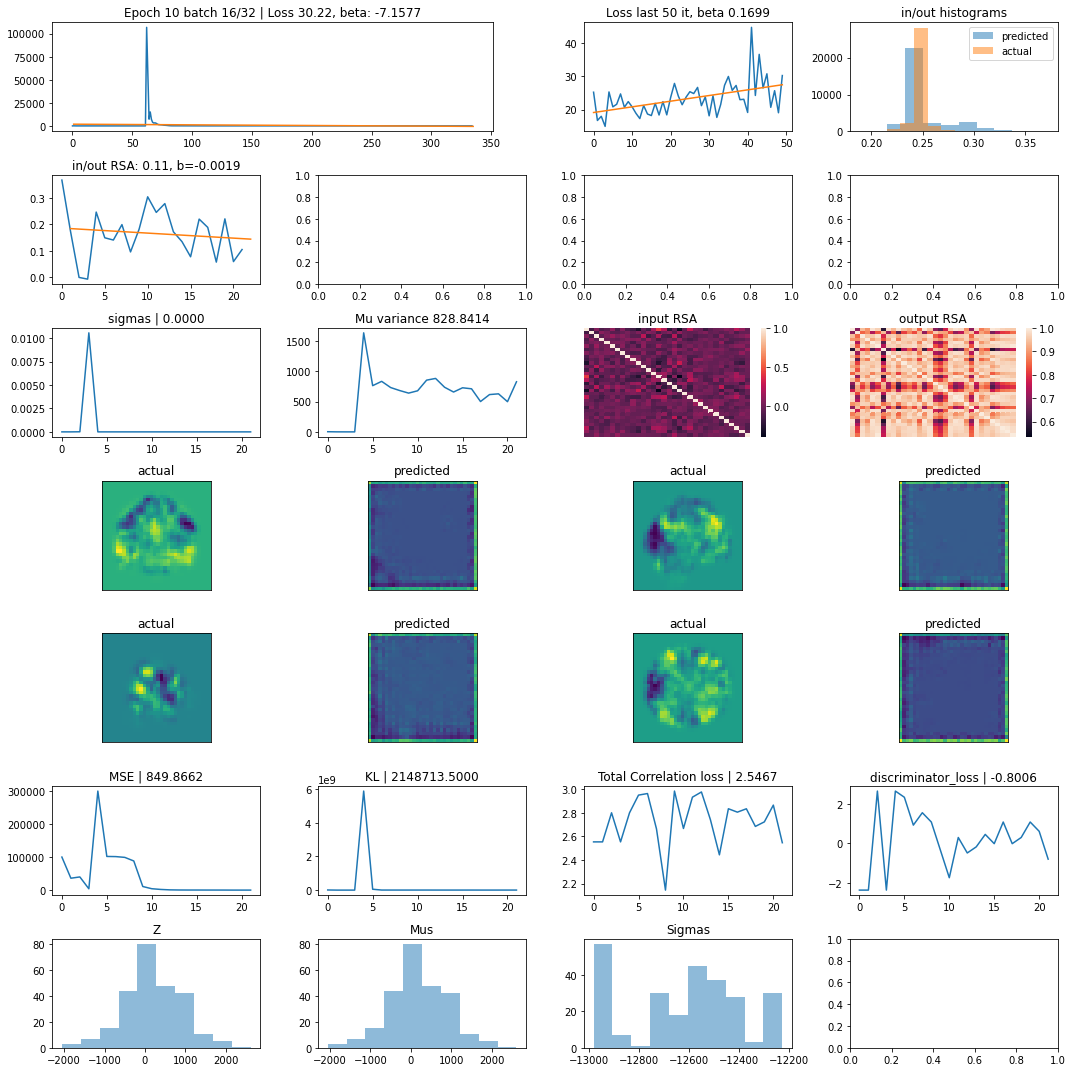

  8%|▊         | 8/100 [05:07<58:52, 38.40s/it]


KeyboardInterrupt: 

In [87]:
for epoch in tqdm(range(100),position=1, leave=True):
    for i in range(data_loader.n_batches):
        data_batch,batch_df = data_loader.get_batch()
        hist = vae.train_on_batch(data_batch) # pass a batch
        assert not np.isnan(hist),'loss is NaN - you f**cked up'  # check nothing crashed
        loss.append(hist) # keep track of loss
        
        if np.mod(i,16)==0:
            vae.save_weights(os.path.join(save_dir,'vae_weights')) # SAVE WEIGHTS
            np.save(os.path.join(save_dir,'vae_loss.npy'),np.array(loss)) # Save loss
            vae_dashboard()